## Chap04_고객의 행동을 예측하는 테크닉

3장에서 사전 분석한 스포츠 센터 회원의 행동 정보를 이용해서 머신러닝으로 예측 

* 회원의 행동은 이용 빈도 등에 따라 경향이 크게 달라진다.

* 군집화(클러스터링)이라는 기법을 이용하면 히ㅗ원을 그룹화할 수 있고, 각 그룹의 행동 패턴을 파악함으로써 미래 예측의 정확도를 높이는 것이 가능해짐

### 전제 조건

* 3장에서 이용 이력을 집계한 결과에 고객 데이터를 결합한 customer_join.csv 가 추가됨

### 테크닉 31 : 데이터를 읽어 들이고 확인

In [57]:
import pandas as pd 
uselog = pd.read_csv('use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [58]:
customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### 테크닉 32 : 클러스터링으로 회원을 그룹화 

customer 데이터를 사용해서 회원 그룹화 진행 

In [59]:
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
customer_clustering.head()

mean  median  max  min  membership_period
0  4.833333     5.0    8    2                 47
1  5.083333     5.0    7    3                 47
2  4.583333     5.0    6    3                 47
3  4.833333     4.5    7    2                 47
4  3.916667     4.0    6    1                 47

* 클러스터링 방법 : K-means (변수 간의 거리를 기반으로 그룹화를 진행)

* 그룹화하고자 하는 수를 미리 지정해야함, 4장에서는 4개의 그룹으로 지정 

* membership_period는 다른 컬럼들과 데이터 크기 차이가 커서 표준화 진행 

In [60]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering) # 표준화 실행 후 저장 

kmeans = KMeans(n_clusters = 4, random_state =0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

C:\Users\Gong\anaconda3\envs\study\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[3 2 0 1]


C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\4053747815.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_clustering["cluster"] = clusters.labels_


mean  median  max  min  membership_period  cluster
0  4.833333     5.0    8    2                 47        3
1  5.083333     5.0    7    3                 47        3
2  4.583333     5.0    6    3                 47        3
3  4.833333     4.5    7    2                 47        3
4  3.916667     4.0    6    1                 47        3

In [61]:
customer_clustering.columns = ["월평균값", "월중앙값", "월최댓값", "월최솟값", "회원기간", "cluster"]
customer_clustering.groupby("cluster").count()

월평균값  월중앙값  월최댓값  월최솟값  회원기간
cluster                              
0        1334  1334  1334  1334  1334
1         846   846   846   846   846
2         763   763   763   763   763
3        1249  1249  1249  1249  1249

#### 결과 
* 그룹 0이 가장 많아 1334명의 고객 존재, 다음으로 그룹3, 그룹1, 그룹2 순서다.

이 그룹의 특징 파악하기 위한 그룹마다의 평균값 계산

In [62]:
customer_clustering.groupby("cluster").mean()

월평균값      월중앙값       월최댓값      월최솟값       회원기간
cluster                                                    
0        5.524239  5.375187   8.745877  2.687406  14.843328
1        8.054608  8.039598  10.009456  6.160757   7.072104
2        3.054713  2.888598   4.756225  1.653997   9.263434
3        4.677494  4.671337   7.232986  2.153723  36.915933

### 테크닉 34 : 클러스터링 결과를 가시화 


* 클러스터링에 사용한 변수는 5개
* 5개의 변수를 2차원으로 그리기 위해 차원 축소 

* 차원 축소 : 비지도학습의 일종, 정보를 되도록 잃지 않게 하면서 새로운 축 생성하는 것 
     - 5개의 변수를 2개의 변수로 표현할 수도 있고 그래프로도 그릴 수 있다.
     - 차원 축소의 대표적인 방법인 주성분 분석 사용

In [63]:
customer_clustering_sc

array([[-0.28120614, -0.13367635,  0.08117747, -0.5336197 ,  2.03402524],
       [-0.14054502, -0.13367635, -0.37992814, -0.02114919,  2.03402524],
       [-0.42186727, -0.13367635, -0.84103375, -0.02114919,  2.03402524],
       ...,
       [ 1.50050144,  1.46662237,  0.08117747,  2.54120338, -1.28811491],
       [ 3.18843493,  3.06692109,  1.46449428,  4.07861492, -1.28811491],
       [ 2.62579043,  2.53348819,  1.00338868,  3.56614441, -1.28811491]])

In [64]:
from sklearn.decomposition import PCA 
X = customer_clustering_sc
pca = PCA(n_components = 2) # 2차원 모델 실행 
pca.fit(X)
x_pca = pca.transform(X) # 주성분 분석 실행 
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

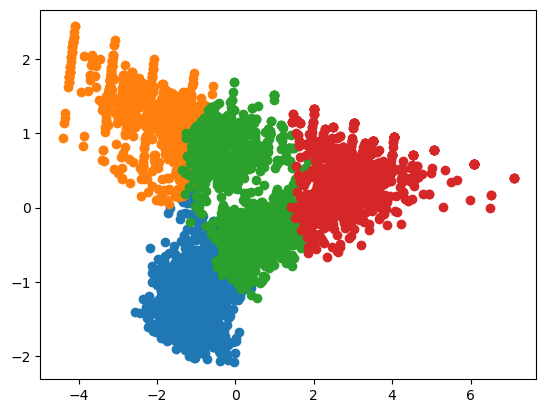

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique() :
    tmp = pca_df.loc[pca_df["cluster"] == i]
    plt.scatter(tmp[0], tmp[1])

### 테크닉 35 : 클러스터링 결과를 바탕으로 탈퇴 회원의 경향을 파악 

클러스터링으로 4개의 그룹으로 분할, 이 그룹에 지속 회원과 탈퇴 회원은 얼마나 있을까?
지속 회원과 탈퇴 회원을 집계 해보기 

* 탈퇴 회원 특정하기 위해서 is_deleted 열을 customer_clustering에 추가해서  cluster 및 is_deleted 별로 집계 해보기

In [66]:
customer_clustering = pd.concat([customer_clustering, customer], axis = 1) # index로 연결되어 있으므로 concat 결합 가능
customer_clustering.groupby(["cluster", "is_deleted"], as_index=False).count()[["cluster", "is_deleted", "customer_id"]]


cluster  is_deleted  customer_id
0        0           0          785
1        0           1          549
2        1           0          827
3        1           1           19
4        2           1          763
5        3           0         1230
6        3           1           19

* 정기적/비정기적 이용 여부 확인

In [67]:
customer_clustering.groupby(["cluster", "routine_flg"], as_index = False).count()[["cluster", "routine_flg", "customer_id"]]

cluster  routine_flg  customer_id
0        0            0          228
1        0            1         1106
2        1            0           52
3        1            1          794
4        2            0          497
5        2            1          266
6        3            0            2
7        3            1         1247

예측 횟수 모델 구축하기

### 테크닉 36 : 다음 달의 이용 횟수 예측을 위해 데이터 준비

고객의 과거 행동 데이터로부터 다음 달의 이용 횟수를 예측하는 경우에는 지도학습의 회귀 분석을 이용 
* 지도 학습 : 미리 정답을 알고 잇는 숫자 데이터 이용해서 예측 
    - 이번에 예측하고 싶은 이용 횟수도 숫자 데이터이기 때문에 지도 학습의 회귀분석이 가능

uselog 데이터를 이용해 연월, 회원마다 집계 

In [68]:
uselog

log_id customer_id     usedate
0       L00000049012330    AS009373  2018-04-01
1       L00000049012331    AS015315  2018-04-01
2       L00000049012332    AS040841  2018-04-01
3       L00000049012333    AS046594  2018-04-01
4       L00000049012334    AS073285  2018-04-01
...                 ...         ...         ...
197423  L00000049209753    TS977703  2019-03-31
197424  L00000049209754    TS979550  2019-03-31
197425  L00000049209755    TS995299  2019-03-31
197426  L00000049209756    TS995853  2019-03-31
197427  L00000049209757    TS999079  2019-03-31

[197428 rows x 3 columns]

In [69]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["연월"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["연월", "customer_id"], as_index = False).count()
uselog_months.rename(columns = {"log_id" : "count"}, inplace = True)
del uselog_months["usedate"]
uselog_months.head()

연월 customer_id  count
0  201804    AS002855      4
1  201804    AS009013      2
2  201804    AS009373      3
3  201804    AS015315      6
4  201804    AS015739      7

In [70]:
year_months = list(uselog_months["연월"].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)) : # 예측을 수행할 기간을 결정하는데 사용
    tmp = uselog_months.loc[uselog_months["연월"] == year_months[i]]
    tmp.rename(columns = {"count" : "count_pred"}, inplace = True)
    for j in range(1, 7) :
        tmp_before = uselog_months.loc[uselog_months["연월"] == year_months[i-j]]
        del tmp_before["연월"]
        tmp_before.rename(columns = {"count" : "count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on = "customer_id", how = "left")
    predict_data = pd.concat([predict_data, tmp], ignore_index =True)
predict_data.head()

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\3299055161.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.rename(columns = {"count" : "count_pred"}, inplace = True)
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\3299055161.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_before.rename(columns = {"count" : "count_{}".format(j-1)}, inplace=True)
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\3299055161.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\3299055161.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_before.rename(columns = {"count" : "count_{}".format(j-1)}, inplace=True)
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\3299055161.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_before.rename(columns = {"count" : "count_{}".format(j-1)}, inplace=True)
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\3299055161.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

연월 customer_id  count_pred  count_0  count_1  count_2  count_3  \
0  201810    AS002855           3      7.0      3.0      5.0      5.0   
1  201810    AS008805           2      2.0      5.0      7.0      8.0   
2  201810    AS009373           5      6.0      6.0      7.0      4.0   
3  201810    AS015233           7      9.0     11.0      5.0      7.0   
4  201810    AS015315           4      7.0      3.0      6.0      3.0   

   count_4  count_5  
0      5.0      4.0  
1      NaN      NaN  
2      4.0      3.0  
3      7.0      NaN  
4      3.0      6.0

* 머신러닝을 진행하는 경우에는 결측치를 처리해야 하므로 dropna로 결측치를포함하는 데이터로 삭제한 후 index를 초기화 한다. 
    - 기본 데이터 완성

In [71]:
predict_data =predict_data.dropna()
predict_data = predict_data.reset_index(drop = True)
predict_data.head()

연월 customer_id  count_pred  count_0  count_1  count_2  count_3  \
0  201810    AS002855           3      7.0      3.0      5.0      5.0   
1  201810    AS009373           5      6.0      6.0      7.0      4.0   
2  201810    AS015315           4      7.0      3.0      6.0      3.0   
3  201810    AS015739           5      6.0      5.0      8.0      6.0   
4  201810    AS019860           7      5.0      7.0      4.0      6.0   

   count_4  count_5  
0      5.0      4.0  
1      4.0      3.0  
2      3.0      6.0  
3      5.0      7.0  
4      8.0      6.0

대상 회원은 6개월 이상 재적 중인 회원이 된다.

### 테크닉 37 : 특징이 되는 변수를 추가하자

* 특징이되는 데이터를 추가, 여기서는 회원 기간을 추가 
    - 회원 기간은 시계열 변화를 볼 수 있기 때문에 기본 데이터가 시계열 데이터인 경우 유효할 가능성이 있다.
    - 고객 데이터인 customer의 start_date 칼럼을 앞에서 작성한 predict_data 에 결합

In [72]:
predict_data = pd.merge(predict_data, customer[["customer_id", "start_date"]], on="customer_id", how="left")
predict_data.head()

연월 customer_id  count_pred  count_0  count_1  count_2  count_3  \
0  201810    AS002855           3      7.0      3.0      5.0      5.0   
1  201810    AS009373           5      6.0      6.0      7.0      4.0   
2  201810    AS015315           4      7.0      3.0      6.0      3.0   
3  201810    AS015739           5      6.0      5.0      8.0      6.0   
4  201810    AS019860           7      5.0      7.0      4.0      6.0   

   count_4  count_5  start_date  
0      5.0      4.0  2016-11-01  
1      4.0      3.0  2015-11-01  
2      3.0      6.0  2015-07-01  
3      5.0      7.0  2017-06-01  
4      8.0      6.0  2017-10-01

연월과 start_date의 차이를 이용해 회원 기간을 월 단위로 작성

In [73]:
predict_data["now_date"] = pd.to_datetime(predict_data["연월"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta # 두 날짜 간의 차이 계산
predict_data["period"] = None # period열에 추가 모든행에 초기값으로 None 할당
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years*12 + delta.months
predict_data.head()

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_12496\1747460443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

연월 customer_id  count_pred  count_0  count_1  count_2  count_3  \
0  201810    AS002855           3      7.0      3.0      5.0      5.0   
1  201810    AS009373           5      6.0      6.0      7.0      4.0   
2  201810    AS015315           4      7.0      3.0      6.0      3.0   
3  201810    AS015739           5      6.0      5.0      8.0      6.0   
4  201810    AS019860           7      5.0      7.0      4.0      6.0   

   count_4  count_5 start_date   now_date period  
0      5.0      4.0 2016-11-01 2018-10-01     23  
1      4.0      3.0 2015-11-01 2018-10-01     35  
2      3.0      6.0 2015-07-01 2018-10-01     39  
3      5.0      7.0 2017-06-01 2018-10-01     16  
4      8.0      6.0 2017-10-01 2018-10-01     12

### 테크닉 38 : 다음 달 이용 횟수를 예측하는 모델을 구축

* 2018년 4월 이후에 새로 가입한 회원만 이용해서 모델 작성
    - 오래전부터 있던 회원은 가입 시기 데이터가 존재하지 않거나 이용 횟수가 안정적일 가능성이 있기 때문에 오래된 회원은 빼고 모델을 구축
    
* 사용할 회귀 모델 : scikit-learn의 LinearRegression
    - 선형회귀 모델

In [74]:
predict_data = predict_data.loc[predict_data["start_date"] >=pd.to_datetime("20180401")] # 2018년 4월 이후에 새로 들어온 회원 추출
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()
X = predict_data[["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y) # 학습 75%, 평가 25% 
model.fit(X_train, y_train)

LinearRegression()

정확도 검증

In [75]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6162897490568044
0.578856665843723


### 테크닉 39 : 모델에 기여하는 변수 확인

설명 변수마다 기여하는 계수 출력

In [77]:
coef = pd.DataFrame({"feature_names" :X.columns, "coefficient":model.coef_})
coef

feature_names  coefficient
0       count_0     0.347858
1       count_1     0.232057
2       count_2     0.152275
3       count_3     0.162888
4       count_4     0.070745
5       count_5     0.047227
6        period     0.053383

count_o이 가장 크고, 과거로 거슬러 올라 갈수록 기여도가 작아지는 경향 확인
* 이전 달의 이용 횟수가 다음 달의 이용 횟수에 영향을 미치고 있음

### 테크닉 40 : 다음 달의 이용 횟수 예측

회원 두 명의 이용 데이터 작성
* 첫 번째 회원 : 6개월 전부터 1개월마다 7, 8, 6, 4, 4, 3번 방문 
* 두 번째 회원 : 6개월 전부터 1개월마다 6, 4, 3, 3, 2, 2번 방문
    - 두 회원의 재적 기간은 8개월 
    - 두 회원의 다음 달 방문 횟수 예측

In [79]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [80]:
model.predict(x_pred)

C:\Users\Gong\anaconda3\envs\study\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([3.71180438, 1.92868653])

결과 
* 회원 1과 회원 2의 예측결과가 array로 반환됨 
    - 첫 번째 회원 : 3.7회 
    - 두 번째 회원 : 1.9회
    
* 실제로 구축한 모델을 시스템으로 만들고 이번 달이 끝나는 시점에 과거의 데이터로부터 다음 달의 이용 횟수를 한 번에 예측할 수 있음 


In [81]:
uselog_months.to_csv("use_log_months.csv", index=False)